In [1]:
import qiskit
import random
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.2', 'qiskit-aer': '0.11.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import *
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
p=int(input("enter layer number: "))
nodes = int(input("enter number of nodes for linear graph - make sure for it to be an even number: "))

enter layer number: 5
enter number of nodes for linear graph - make sure for it to be an even number: 4


'seed = 452002\nG = nx.path_graph(nodes)\npos = {\n    0: (0, 0),\n    1: (1, 0),\n    2: (2, 0),\n    3: (0.5, 1),\n}\nnx.draw(G, pos=pos, with_labels=True)'

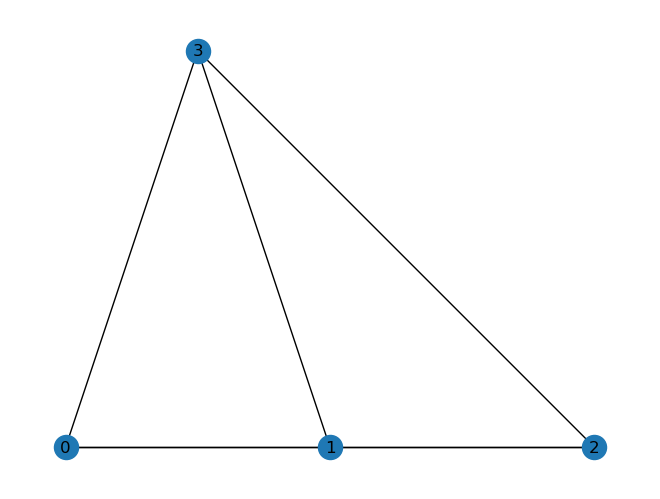

In [3]:
seed = 1158
G = nx.complete_graph(4)
pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (0.5, 1),
}
nx.draw(G, pos=pos, with_labels=True)
'''seed = 452002
G = nx.path_graph(nodes)
pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (0.5, 1),
}
nx.draw(G, pos=pos, with_labels=True)'''


In [4]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc

In [5]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────■────■──────────────────────────»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                │    │                          »
q_1: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼────────────────┼────┼───────■──────────────────»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐  │     ┌─┴─┐    ┌──────────┐»
q_2: ──────────────────────┤ X ├┤ Rz(2π/3) ├┤ X ├──┼─────┤ X ├────┤ Rz(2π/3) ├»
                           └───┘└──────────┘└───┘┌─┴─┐┌──┴───┴───┐└──────────┘»
q_3: ────────────────────────────────────────────┤ X ├┤ Rz(2π/3) ├────────────»
                                                 └───┘└──────────┘            »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_3: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                           
«q_0: ──■───────────────────────────────────────────────────
«       │                                                   
«q_1: ──┼────■────■────────────────■────────────────────────
«       │  ┌─┴─┐  │                │                        
«q_2: ──┼──┤ X ├──┼────────────────┼────■────────────────■──
«     ┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐
«q_3: ┤ X ├─────┤ X ├┤ Rz(2π/3) ├┤ X ├┤ X ├┤ Rz(2π/3) ├┤ X ├
«     └───┘     └───┘└──────────┘└───┘└───┘└──────────┘└───┘
«c_0: ══════════════════════════════════════════════════════
«                                                           
«c_1: ══════════════════════════════════════════════════════
«                                                           
«c_2: ══════════════════════════════════════════════════════
«                                                           
«c_3: ══════════════════════════════════════════════════════
«

In [6]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

In [7]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     └──────────┘
c_0: ════════════
                 
c_1: ════════════
                 
c_2: ════════════
                 
c_3: ════════════

In [8]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

In [9]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])


┌───┐                                                                  »
q_0: ┤ H ├──■─────────────■────■─────────────■────■──────────────────────■──»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │  »
q_1: ┤ H ├┤ X ├┤ Rz(π) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼──»
     ├───┤└───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  »
q_2: ┤ H ├───────────────────┤ X ├┤ Rz(π) ├┤ X ├──┼────┤ X ├──┤ Rz(π) ├──┼──»
     ├───┤                   └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐»
q_3: ┤ H ├──────────────────────────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├»
     └───┘                                      └───┘└───────┘         └───┘»
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_2: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_3: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌──────────┐                                                          ░ »
«q_0: ┤ Rx(2π/3) ├──────────────────────────────────────────────────────────░─»
«     └──────────┘                   ┌──────────┐                           ░ »
«q_1: ─────■────────■─────────────■──┤ Rx(2π/3) ├───────────────────────────░─»
«        ┌─┴─┐      │             │  └──────────┘              ┌──────────┐ ░ »
«q_2: ───┤ X ├──────┼─────────────┼───────■─────────────────■──┤ Rx(2π/3) ├─░─»
«        └───┘    ┌─┴─┐┌───────┐┌─┴─┐   ┌─┴─┐    ┌───────┐┌─┴─┐├──────────┤ ░ »
«q_3: ────────────┤ X ├┤ Rz(π) ├┤ X ├───┤ X ├────┤ Rz(π) ├┤ X ├┤ Rx(2π/3) ├─░─»
«                 └───┘└───────┘└───┘   └───┘    └───────┘└───┘└──────────┘ ░ »
«c_0: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«c_1: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«c_2: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«c_3: ════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌─┐         
«q_0: ┤M├─────────
«     └╥┘┌─┐      
«q_1: ─╫─┤M├──────
«      ║ └╥┘┌─┐   
«q_2: ─╫──╫─┤M├───
«      ║  ║ └╥┘┌─┐
«q_3: ─╫──╫──╫─┤M├
«      ║  ║  ║ └╥┘
«c_0: ═╩══╬══╬══╬═
«         ║  ║  ║ 
«c_1: ════╩══╬══╬═
«            ║  ║ 
«c_2: ═══════╩══╬═
«               ║ 
«c_3: ══════════╩═
«

In [10]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [11]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'0001': 57, '1100': 70, '0110': 68, '1011': 64, '0010': 71, '1010': 47, '0101': 71, '1000': 65, '0100': 65, '1101': 81, '1111': 63, '0011': 58, '1110': 50, '1001': 56, '0000': 71, '0111': 67}


In [12]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('0001100000', G)

-3

In [13]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.96875

In [14]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

In [15]:
obj = get_black_box_objective(G, p)
#random.seed(69)

my_array = []

for i in range(p):
    my_array.append(random.uniform(0, np.pi))

for i in range(p):
    my_array.append(random.uniform(0, 2*np.pi))

print(my_array)
    
init_point = my_array
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':100, 'disp': True})
res_sample

[1.5298441880123768, 1.7721633208004364, 1.0552215156102849, 2.833558116805888, 2.881126970945502, 3.051020589198799, 4.355863193725365, 6.185363126169098, 1.2781613116010158, 2.0872865046707414]


C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])


     fun: -3.9814453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 95
  status: 1
 success: True
       x: array([1.55030012, 1.82893517, 1.03752834, 2.82856544, 2.86868742,
       2.98840517, 4.30360852, 7.18109727, 1.3665305 , 2.07631323])

In [16]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts


C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1074017623.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])


{'0101': 179,
 '1001': 164,
 '1100': 152,
 '0011': 153,
 '0110': 194,
 '0111': 1,
 '1010': 161,
 '0010': 4,
 '1011': 2,
 '0000': 1,
 '1110': 1,
 '0001': 3,
 '1101': 3,
 '1000': 2,
 '0100': 4}

In [17]:
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
        
sim_noise=AerSimulator(noise_model=noise_bit_flip)
qc_bitnoise=transpile(qc, sim_noise)
result_bit_flip = sim_noise.run(qc_bitnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)
counts = counts_bit_flip
counts

{'0000': 75,
 '1100': 75,
 '0011': 63,
 '0110': 66,
 '1010': 58,
 '0111': 57,
 '1110': 60,
 '0101': 69,
 '0100': 58,
 '0001': 65,
 '1101': 71,
 '1001': 66,
 '1111': 56,
 '1000': 73,
 '0010': 55,
 '1011': 57}

In [18]:
import numpy as np

def state_num2str(basis_state_as_num, nqubits):
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
         adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

In [19]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
    return qc

In [20]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts

In [21]:
backend = Aer.get_backend('statevector_simulator')
qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
matrix=state_to_ampl_counts(sv)
state_to_ampl_counts(sv)
#sv



C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1706904653.py:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_26104\1706904653.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_26104\223565038.py:15: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. T

{'0000': (-0.005074764425409359-0.01837462879569328j),
 '0001': (-0.034607815506192706+0.03449359291826833j),
 '0010': (-0.034607815506192574+0.03449359291826833j),
 '0011': (-0.23438435903816768+0.3292812886228436j),
 '0100': (-0.03460781550619275+0.03449359291826844j),
 '0101': (-0.23438435903816768+0.3292812886228434j),
 '0110': (-0.23438435903816754+0.32928128862284356j),
 '0111': (-0.03460781550619273+0.034493592918268326j),
 '1000': (-0.03460781550619262+0.03449359291826834j),
 '1001': (-0.23438435903816765+0.32928128862284356j),
 '1010': (-0.23438435903816765+0.3292812886228437j),
 '1011': (-0.034607815506192706+0.03449359291826836j),
 '1100': (-0.2343843590381677+0.3292812886228436j),
 '1101': (-0.03460781550619254+0.03449359291826833j),
 '1110': (-0.034607815506192734+0.034493592918268354j),
 '1111': (-0.005074764425409259-0.018374628795693314j)}

In [22]:
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
        
sim_noise=AerSimulator(noise_model=noise_bit_flip)
qc_bitnoise = transpile(qc, sim_noise)
result_bit_flip = sim_noise.run(qc_bitnoise).result()
sv1 = get_adjusted_state(result_bit_flip.get_statevector(0))
matrix=state_to_ampl_counts(sv1)
state_to_ampl_counts(sv1)

QiskitError: 'No statevector for experiment "0"'

In [ ]:
values = np.array(list(matrix.values()))
output = np.reshape(values, (-1, 2**(int(nodes/2)))) # reshape the array and extract the amplitudes
print(output)

In [ ]:
truematrix = output.T
print(truematrix)

In [ ]:
import scipy.linalg

U, D, V = scipy.linalg.svd(truematrix)
print(D)

In [ ]:
precision = 4

singular = [round(num, precision) for num in D]
print(singular)

In [ ]:
import math
total = 0
for num in singular:
    if num != 0:
        total += (-1)*(num**2 * math.log(num**2))

print("for", p, "entropy is", total)